# Photometry Tutorial

TODO: Flesh out this notebook with more explanations, assumptions, things to keep in mind,
etc.

RED LEAK IS NOT IMPLEMENTED YET!

In [1]:
# I only need the following line since I'm using remote VS Code
%cd "/arc/home/IsaacCheng/CASTOR/ETC/notebooks"

import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display

# Import my own modules
import sys
sys.path.append("../")
from castor_etc.photometry import Photometry
from castor_etc.telescope import Telescope
from castor_etc.sources import PointSource, ExtendedSource, Profiles
from castor_etc.background import Background
from castor_etc import parameters as params
from castor_etc.data.background import background_values

import importlib
from castor_etc import photometry as phot
from castor_etc import sources as src

/arc/home/IsaacCheng/CASTOR/ETC/notebooks


In [11]:
importlib.reload(src)
importlib.reload(phot)
#
# Define telescope instance
#
MyTelescope = Telescope(px_scale=0.1 * u.arcsec)
#
# Generate background object
#
# MyBackground = Background(mags_per_sq_arcsec=background_values.SKY_BACKGROUND)
MyBackground = Background()
#
# Create source
#
MySource = src.PointSource(src.Profiles.uniform(), angle=0.1 * u.arcsec)
wavelengths = np.arange(0.1, 1.2, 0.001) * u.um
bb_temps = [3000, 4000, 5000, 7000, 10000, 15000, 20000, 30000, 40000, 50000]  # kelvin
redleak_fracs = dict.fromkeys(bb_temps)
for temp in bb_temps:
    MySource.generate_bb(temp, overwrite=True)  # (in erg/s/cm^2/A)
    MyPhot = phot.Photometry(MyTelescope, MySource, MyBackground)
    MyPhot.use_optimal_aperture(quiet=True)
    redleak_fracs[temp] = MyPhot.calc_snr_or_t(snr=5)  # now no longer returns the redleak fraction. Just for debugging
display(pd.DataFrame(redleak_fracs))

INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.


,3000,4000,5000,7000,10000,15000,20000,30000,40000,50000
uv,2.993948e+00,3.637762e-01,1.005594e-01,2.210276e-02,6.771711e-03,2.650691e-03,1.672792e-03,1.079639e-03,8.799739e-04,7.832349e-04
u,1.800051e-05,6.234715e-06,3.240357e-06,1.515118e-06,8.616019e-07,5.686044e-07,4.693222e-07,3.934773e-07,3.628285e-07,3.464603e-07
g,1.612818e-11,1.120794e-11,8.845189e-12,6.659134e-12,5.374314e-12,4.585031e-12,4.258533e-12,3.976177e-12,3.851018e-12,3.780887e-12


## Uniform Spectrum & No Redleak


When normalizing a spectrum so that it has a given flux density or magnitude within a
certain passband, I sum the flux within that passband and normalize so that this total
flux is equal to the given value... This does NOT seem to produce correct SNRs/times if I
use the passband response curves to convert the spectra to electron/s.

(Compare with the code cell below the next markdown cell)


In [61]:
importlib.reload(src)
importlib.reload(phot)

%matplotlib widget

#
# Define telescope instance
#
MyTelescope = Telescope(px_scale=0.1 * u.arcsec)
# 
# Generate background object
# 
# MyBackground = Background(mags_per_sq_arcsec=background_values.SKY_BACKGROUND)
MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="avg")
# 
# Create source
#
# MySource = src.PointSource(
#     src.Profiles.ellipse(a0=0.5 * u.arcsec, b0=0.2 * u.arcsec, angle=45), angle=1 * u.arcsec
# )
MySource = src.PointSource(src.Profiles.uniform(), angle=0.1 * u.arcsec)
wavelengths = np.arange(0.1, 1.2, 0.001) * u.um
MySource.generate_uniform(wavelengths=wavelengths, value=1.0)  # (in erg/s/cm^2/A)

fig, ax = plt.subplots()
ax.plot(MySource.wavelengths.value, MySource.spectrum, "k")
ax.fill_between(MySource.wavelengths.value, MySource.spectrum, alpha=0.5)
ax.set_xlabel("Wavelength [\AA]")
ax.set_ylabel(r"Un-Normalized Flux Density [$\rm erg\, s^{-1}\, cm^{-2}\,$\AA$^{-1}$]")
ax.set_ylim(bottom=0)
plt.show()

# MySource.norm_to_value(
#     22.0,
#     "mag",
#     passband_lims=MyTelescope.passband_limits["u"],
#     pivot_wavelength=MyTelescope.passband_pivots["u"],
# )
# fig, ax = plt.subplots()
# ax.plot(MySource.wavelengths.value, MySource.spectrum, "k")
# ax.fill_between(MySource.wavelengths.value, MySource.spectrum, alpha=0.5)
# ax.set_xlabel("Wavelength [\AA]")
# ax.set_ylabel(r"Flux Density [$\rm erg\, s^{-1}\, cm^{-2}\,$\AA$^{-1}$]")
# ax.set_ylim(bottom=0)
# plt.show()

MyPhot = phot.Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(a=0.1 * u.arcsec, b=0.4 * u.arcsec, center=[0, 0.1] << u.arcsec, rotation=20)
# MyPhot.use_rectangular_aperture(width=2 * u.arcsec, length=1 * u.arcsec, center=[0, 4] << u.arcsec, weight_res=0.01)
# MyPhot.use_rectangular_aperture(width=2 * u.arcsec, length=1 * u.arcsec, center=[0.5, 0] << u.arcsec)
# MyPhot.use_optimal_aperture(factor=1.4)
# MyPhot.source_weights[np.isnan(MyPhot.source_weights)] = 1
MyPhot.show_source_weights(mark_source=True, source_markersize=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/arc/home/IsaacCheng/CASTOR/ETC/notebooks/../castor_etc/photometry.py:619: RuntimeWarning: Chosen a/b is smaller than the 'ideal' aperture size for this source! a & b should be at least 0.105 arcsec.
  warnings.warn(


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [59]:
importlib.reload(phot)
results_per_band = dict.fromkeys(MyTelescope.passbands)
for band in MyTelescope.passbands:
    MySource.norm_to_value(
        22.0,
        "mag",
        passband_lims=MyTelescope.passband_limits[band],
        pivot_wavelength=MyTelescope.passband_pivots[band],
    )
    MyPhot = phot.Photometry(MyTelescope, MySource, MyBackground)
    MyPhot.use_optimal_aperture(quiet=True)
    results = MyPhot.calc_snr_or_t(snr=5, include_redleak=False)
    results_per_band[band] = results[band]
    # results = MyPhot.calc_snr_or_t(t=4.343751, include_redleak=False)
    print(f"RESULTS for {band}-band", results[band])
    print()
for band in MyTelescope.passbands:
    MySource.norm_to_value(
        22.0,
        "mag",
        passband_lims=MyTelescope.passband_limits[band],
        pivot_wavelength=MyTelescope.passband_pivots[band],
    )
    MyPhot = phot.Photometry(MyTelescope, MySource, MyBackground)
    MyPhot.use_optimal_aperture(quiet=True)
    # results = MyPhot.calc_snr_or_t(snr=5, include_redleak=False)
    results = MyPhot.calc_snr_or_t(t=results_per_band[band], include_redleak=False)
    print(f"RESULTS for {band}-band", results[band])
    print()


RESULTS for uv-band 3.7439838495210287

RESULTS for u-band 3.5868688693588586

RESULTS for g-band 2.848482112683075

RESULTS for uv-band 5.0

RESULTS for u-band 5.0

RESULTS for g-band 5.0



The following cell used the total flux in the passband + photometric zero-points to
convert flam to electron/s. This is the correct (expected) behaviour...
  

{'uv': 24.463, 'u': 24.511, 'g': 24.766}
{'uv': <Quantity 0.22047495 um>, 'u': <Quantity 0.34375662 um>, 'g': <Quantity 0.47077832 um>}
{'uv': <Quantity 3880. Angstrom>, 'u': <Quantity 4730. Angstrom>, 'g': <Quantity 5660. Angstrom>}
10990.000000000007


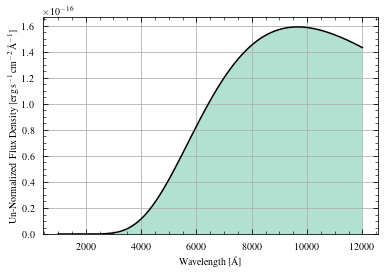

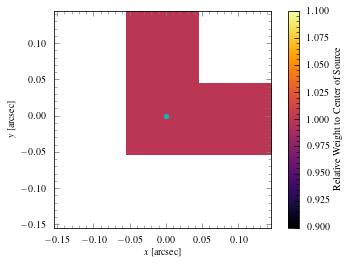

RESULTS for uv-band 10.646077955326872

RESULTS for u-band 3.3695991837660824

RESULTS for g-band 2.6807393517220843



In [3]:
importlib.reload(src)
importlib.reload(phot)

%matplotlib inline
#
# Define telescope instance
#
# MyTelescope = Telescope(px_scale=0.1 * u.arcsec, phot_zpts=params.PHOT_ZPTS, passband_pivots=params.PASSBAND_PIVOTS)
MyTelescope = Telescope(px_scale=0.1 * u.arcsec, phot_zpts=None, passband_pivots=None)
print(MyTelescope.phot_zpts)
print(MyTelescope.passband_pivots)
print(MyTelescope.redleak_thresholds)
print(MyTelescope.full_passband_curves['uv']['wavelength'][-1].to(u.AA).value)
# 
# Generate background object
# 
MyBackground = Background(mags_per_sq_arcsec=background_values.SKY_BACKGROUND)
MyBackground.add_geocoronal_emission(flux="avg")
# 
# Create source
#
# MySource = src.PointSource(
#     src.Profiles.ellipse(a0=0.5 * u.arcsec, b0=0.2 * u.arcsec, angle=45), angle=1 * u.arcsec
# )
MySource = src.PointSource(src.Profiles.uniform(), angle=0.1 * u.arcsec)
wavelengths = np.arange(0.1, 1.2, 0.001) * u.um
# MySource.generate_uniform(wavelengths=wavelengths, value=1.0)  # (in erg/s/cm^2/A)
MySource.generate_bb(3000)  # (in erg/s/cm^2/A)

fig, ax = plt.subplots()
ax.plot(MySource.wavelengths.value, MySource.spectrum, "k")
ax.fill_between(MySource.wavelengths.value, MySource.spectrum, alpha=0.5)
ax.set_xlabel("Wavelength [\AA]")
ax.set_ylabel(r"Un-Normalized Flux Density [$\rm erg\, s^{-1}\, cm^{-2}\,$\AA$^{-1}$]")
ax.set_ylim(bottom=0)
plt.show()

_show_weights = True
for band in MyTelescope.passbands:
    MySource.norm_to_value(
        22.0,
        "mag",
        passband_lims=MyTelescope.passband_limits[band],
        pivot_wavelength=MyTelescope.passband_pivots[band],
    )
    MyPhot = phot.Photometry(MyTelescope, MySource, MyBackground)
    # MyPhot.use_rectangular_aperture(width=0.8 * u.arcsec, length=1* u.arcsec, center=[0, 0] << u.arcsec)
    MyPhot.use_optimal_aperture(quiet=True)
    if _show_weights:
        MyPhot.show_source_weights(mark_source=True, source_markersize=4)
        _show_weights = False  # only display once
    results = MyPhot.calc_snr_or_t(snr=5, include_redleak=True)
    # results = MyPhot.calc_snr_or_t(t=4.343751, include_redleak=False)
    # Notice g-band will eventually take the longest to reach a given SNR. This is correct
    print(f"RESULTS for {band}-band", results[band])
    print()


## Blackbody Spectrum


In [2]:
importlib.reload(src)
importlib.reload(phot)

%matplotlib widget

#
# Define telescope instance
#
MyTelescope = Telescope(px_scale=0.1 * u.arcsec)
# 
# Generate background object
# 
MyBackground = Background()
MyBackground.add_geocoronal_emission()
#
# Create source
#
# MySource = src.PointSource(
#     src.Profiles.ellipse(a0=0.5 * u.arcsec, b0=0.2 * u.arcsec, angle=45), angle=1 * u.arcsec
# )
MySource = src.PointSource(src.Profiles.uniform(), angle=0.1 * u.arcsec)
MySource.generate_bb(5500 * u.K, redshift=0, radius=1, dist=1 * u.kpc)
# (spectrum is in erg/s/cm^2/A)
MySource.norm_to_value(
    22.0,
    "mag",
    passband_lims=MyTelescope.passband_limits["u"],
    pivot_wavelength=MyTelescope.passband_pivots["u"],
)
fig, ax = plt.subplots()
ax.plot(MySource.wavelengths, MySource.spectrum)
plt.show()

MyPhot = phot.Photometry(MyTelescope, MySource, MyBackground)
# MyPhot.use_elliptical_aperture(a=0.4 * u.arcsec, b=0.4 * u.arcsec, center=[0, 0.1] << u.arcsec)
# MyPhot.use_rectangular_aperture(width=2 * u.arcsec, length=1 * u.arcsec, center=[0, 4] << u.arcsec, weight_res=0.01)
# MyPhot.use_rectangular_aperture(width=2 * u.arcsec, length=1 * u.arcsec, center=[0.5, 0] << u.arcsec)
MyPhot.use_optimal_aperture()
MyPhot.show_source_weights(mark_source=True, source_markersize=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

INFO: Source's semimajor axis (a) or radius subtends angle < 1/2 of the FWHM of the telescope's PSF. Using 1/2 of FWHM instead.
INFO: Source's semiminor axis (b) or radius subtends angle < 1/2 of the FWHM of the telescope's PSF. Using 1/2 of FWHM instead.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
results = MyPhot.calc_snr_or_t(snr=3)
# for band in MyPhot.redleaks:
#     print(band, np.nansum(MyPhot.redleaks[band]))
results

uv
redleak flux uv 1.2449880644527248e-17
redleak flux u 1.0645377892165522e-17
redleak flux g 8.447273397186188e-18
source_erate uv 0.31192375381533727
redleak flux fraction uv 27.64611876187363
source_erate u 3.676073988715039
redleak flux fraction u 7.273033379815641
source_erate g 17.44550879999241
redleak flux fraction g 2.489942139524642
uv 8.623481142628247
u 26.736208826596503
g 43.43830750654907


{'uv': 130.94829668639827, 'u': 17.162573477135947, 'g': 3.659294923352023}

## Misc Testing (will remove later)


In [ ]:
importlib.reload(src)
importlib.reload(phot)

%matplotlib widget

#
# Define telescope instance
#
MyTelescope = Telescope(px_scale=0.1 * u.arcsec)
# 
# Generate background object
# 
MyBackground = Background()
MyBackground.add_geocoronal_emission()
MyBackground.calc_sky_background_mags(MyTelescope)
MyBackground.sky_background_mags

In [58]:
def _rotate_ccw(x, y, theta, origin=(0, 0)):
    """
    Rotate a point/array counter-clockwise by theta degrees about the origin. Theta starts
    at zero on the positive x-axis (right) and increases toward the positive y-axis (up).

    Parameters
    ----------
      x, y :: float or array-like
        The x- and y-coordinates of the point/array to rotate.

      theta :: float or array-like
        The angle of rotation in degrees.

      origin :: 2-tuple of floats or array-like with shape (2, shape(x)) (optional)
        The point about which to rotate. Default is (0, 0). If x and y are arrays, this
        should be a 2D array where the first index (row) is the x-coordinate origin and
        the second index (column) is the y-coordinate of the origin.

    Returns
    -------
      x_rot, y_rot :: float or array-like
        The rotated x- and y-coordinates of the point/array.
    """
    theta = np.deg2rad(theta)
    xnew = x - origin[0]
    ynew = y - origin[1]
    xnew2 = np.cos(theta) * xnew - np.sin(theta) * ynew
    ynew2 = np.sin(theta) * xnew + np.cos(theta) * ynew
    x_rot = xnew2 + origin[0]
    y_rot = ynew2 + origin[1]
    return x_rot, y_rot


def _rotate_cw(x, y, theta, origin=(0, 0)):
    """
    Rotate a point/array clockwise by theta degrees about the origin. Theta starts at zero
    on the positive x-axis (right) and increases toward the negative y-axis (down).

    Parameters
    ----------
      x, y :: float or array-like
        The x- and y-coordinates of the point/array to rotate.

      theta :: float or array-like
        The angle of rotation in degrees.

      origin :: 2-tuple of floats or array-like with shape (2, shape(x)) (optional)
        The point about which to rotate. Default is (0, 0). If x and y are arrays, this
        should be a 2D array where the first index (row) is the x-coordinate origin and
        the second index (column) is the y-coordinate of the origin.

    Returns
    -------
      x_rot, y_rot :: float or array-like
        The rotated x- and y-coordinates of the point/array.
    """
    theta = np.deg2rad(theta)
    xnew = x - origin[0]
    ynew = y - origin[1]
    xnew2 = np.cos(theta) * xnew + np.sin(theta) * ynew
    ynew2 = -np.sin(theta) * xnew + np.cos(theta) * ynew
    x_rot = xnew2 + origin[0]
    y_rot = ynew2 + origin[1]
    return x_rot, y_rot

plt.close("all")

my_xs, my_ys = np.meshgrid(np.arange(-10, 11, 1), np.arange(-10, 11, 1), indexing="xy")
my_xs, my_ys = _rotate_ccw(my_xs, my_ys, -45, origin=[0, 0])

fig, ax = plt.subplots()
img = ax.imshow(my_ys, origin="lower")
# img = ax.imshow(my_ys.T, origin="lower")
fig.colorbar(img)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/tmp/ipykernel_5494/1703140273.py:74: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img)


In [46]:
my_ys

array([[-1.  , -1.  , -1.  , ..., -1.  , -1.  , -1.  ],
       [-0.97, -0.97, -0.97, ..., -0.97, -0.97, -0.97],
       [-0.94, -0.94, -0.94, ..., -0.94, -0.94, -0.94],
       ...,
       [ 0.95,  0.95,  0.95, ...,  0.95,  0.95,  0.95],
       [ 0.98,  0.98,  0.98, ...,  0.98,  0.98,  0.98],
       [ 1.01,  1.01,  1.01, ...,  1.01,  1.01,  1.01]])

In [9]:
# %matplotlib widget
# importlib.reload(phot)
# MyPhot = phot.Photometry(MyTelescope, MySource, MyBackground)
# # MyPhot.use_elliptical_aperture(a=1.4 * 0.4 * u.arcsec, b=1.4 * 0.2 * u.arcsec, center=[0, 0] << u.arcsec)
# # MyPhot.use_rectangular_aperture(width=2 * u.arcsec, length=1 * u.arcsec, center=[0, 4] << u.arcsec, weight_res=0.01)
# MyPhot.use_rectangular_aperture(width=1 * u.arcsec, length=1 * u.arcsec, center=[0, 0] << u.arcsec, weight_res=0.01)
# MyPhot.show_source_weights(mark_center=False, center_markersize=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …